# Predict the Man of the Match - FIFA 2018
I found the FIFA 2018 World Cup statistics on the Kaggle. And decide to play around the dataset and see if we can predict which side will win the Man of the Match award. Moreover, a feature engineering technique, SHAP values, will be shown to see which feature has the most influence on the result. I recently learned it from Kaggle Insight, thus I apply it on this case

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

% matplotlib inline

In [4]:
# Read the dataset
fifa_18 = pd.read_csv('FIFA 2018 Statistics.csv') 

# Check the random 5 rows of sample
fifa_18.sample(5)

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,...,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
103,01-07-2018,Denmark,Croatia,1,46,15,3,10,2,4,...,1,0,0,No,1.0,Round of 16,Yes,2,NaN,NaN
45,21-06-2018,Croatia,Argentina,3,42,15,5,6,4,2,...,4,0,0,Yes,53.0,Group Stage,No,0,NaN,NaN
12,16-06-2018,Peru,Denmark,0,52,18,6,7,5,3,...,1,0,0,No,NaN,Group Stage,No,0,NaN,NaN
122,11-07-2018,Croatia,England,2,54,22,7,11,4,8,...,2,0,0,Yes,68.0,Semi- Finals,No,0,NaN,NaN
35,20-06-2018,Morocco,Portugal,0,53,16,4,10,2,7,...,1,0,0,No,NaN,Group Stage,No,0,NaN,NaN


In [5]:
# Check how many missing values (NaN) in the dataset
missing = fifa_18.isnull().sum()
# Print out the columns that have NaNs
print(missing[missing > 0])

1st Goal          34
Own goals        116
Own goal Time    116
dtype: int64


##### It is easier to spot the null values with bar plot

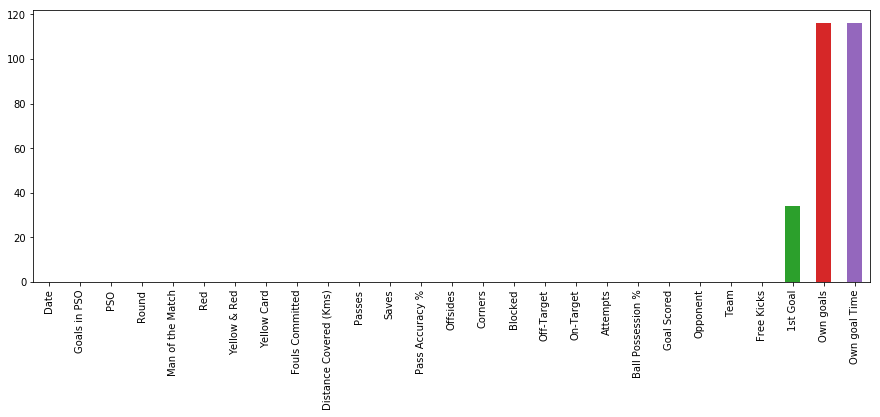

In [6]:
fifa_18.isnull().sum().sort_values().plot(kind='bar', figsize=(15,5))

In [7]:
# Check the percentage of (missing values/total number of values)
total_cells = np.prod(fifa_18.shape)
total_missing = missing.sum()
print('The percentage of missing value to the total number of cells is: ',(total_missing/total_cells)*100)

The percentage of missing value to the total number of cells is:  7.696759259259259


In [8]:
# Replace the NaN in the Own goals column with 0
fifa_18['Own goals'].fillna(0,inplace=True)

# Create two new targets
own_goal_check = fifa_18['Own goals'].apply(lambda x: 0 if x==0 else 1)
fifa_18['If own goal'] = own_goal_check

pso = fifa_18['PSO'].apply(lambda x: 0 if x=='No' else 1)
fifa_18['If PSO'] = pso

# Check the new dataset
fifa_18.sample(5)

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,...,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time,If own goal,If PSO
101,01-07-2018,Russia,Spain,1,25,6,1,3,2,5,...,0,Yes,41.0,Round of 16,Yes,4,1.0,12.0,1,1
30,19-06-2018,Poland,Senegal,1,57,10,4,5,1,3,...,0,No,37.0,Group Stage,No,0,1.0,37.0,1,0
84,27-06-2018,Serbia,Brazil,0,44,10,1,5,4,5,...,0,No,NaN,Group Stage,No,0,0.0,NaN,0,0
68,25-06-2018,Spain,Morocco,2,68,16,4,11,1,7,...,0,Yes,19.0,Group Stage,No,0,0.0,NaN,0,0
88,28-06-2018,Japan,Poland,0,54,10,3,4,3,5,...,0,No,NaN,Group Stage,No,0,0.0,NaN,0,0


In [9]:
# Drop few columns 
cols_to_drop = ['1st Goal',   # it is converted
                'Own goal Time',  # own goal time normally does not matter in football
                'PSO',   # it is converted   
                'Date',  # date is not important because it is fair for both sides
                'Team',  
                'Opponent',
                'Round'  # it is same for both sides
               ]
fifa_18.drop(cols_to_drop,axis=1,inplace=True)
fifa_18.columns

Index(['Goal Scored', 'Ball Possession %', 'Attempts', 'On-Target',
       'Off-Target', 'Blocked', 'Corners', 'Offsides', 'Free Kicks', 'Saves',
       'Pass Accuracy %', 'Passes', 'Distance Covered (Kms)',
       'Fouls Committed', 'Yellow Card', 'Yellow & Red', 'Red',
       'Man of the Match', 'Goals in PSO', 'Own goals', 'If own goal',
       'If PSO'],
      dtype='object')

## EDA

A few plots are presented to make the relationship between the features and target more clear

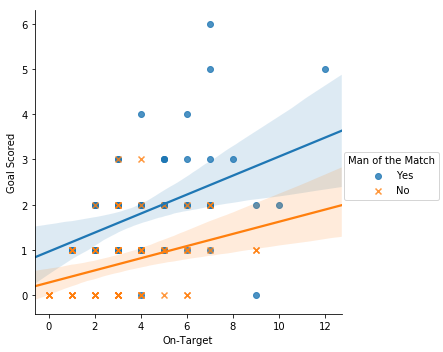

In [10]:
# relationship between goal scored and on-target shots with another dimension on man of the match
sns.lmplot(x='On-Target',y='Goal Scored',hue = 'Man of the Match',data=fifa_18,markers=['o','x'])

It shows the relationship between Goal Scored, On-Target shots and Man of the Match. As expected, it would demonstrate a linear relationship between Goal Scored and On-Target shots as more on-target shots usually mean more chances of scoring. Also, it shows that if a team fails to score, then it is very likely they will not win the Man of the Match award. On the other hand, if a team scores 3 or more goals, then this team has a high likelihood of winning the award.

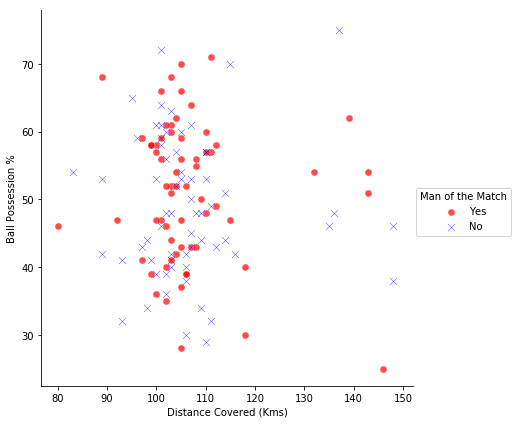

In [11]:
# ball possession vs distance covered with another dimension on man of the match
pal = dict(Yes="red", No="blue")
g = sns.FacetGrid(fifa_18, hue="Man of the Match", palette=pal,hue_kws={"marker": ["o", "x"]},size=6,aspect=1)
g.map(plt.scatter, "Distance Covered (Kms)", "Ball Possession %", s=50, alpha=0.7, linewidth=.5, edgecolor="white")
g.add_legend()

We keep exploring the potential relationship between the features and target. This time, we would like to see the connection between ball possesion, distance covered and the target. It can be observed from the scatter plot that most of the teams cover 100-120 Km in one football match. There are some outliers around 130-150 Km, which is possibly due to the overtime. It will be difficult to distinguish any pattern from this plot as most of the data is overlapped with each other. Having more possesions on the ball or running more distances do not guarantee you the Man of the Match award.

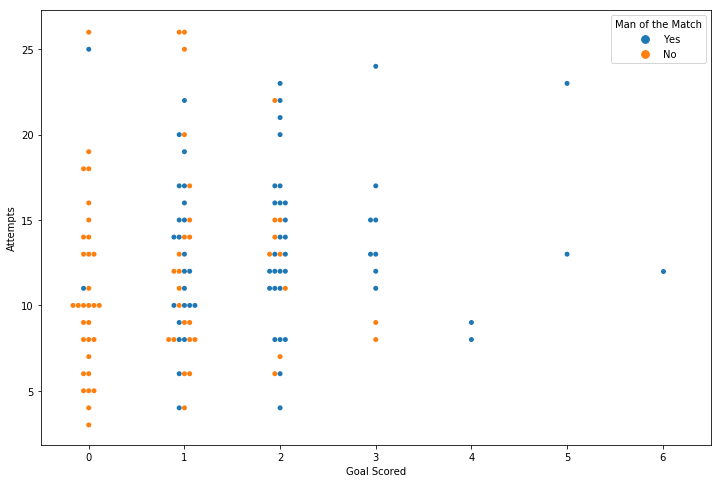

In [14]:
# goal scored vs attempts with another dimension on man of the match
plt.figure(figsize=(12,8))
sns.swarmplot(x="Goal Scored", y="Attempts", hue="Man of the Match", data=fifa_18)

This swarmplot actually provides some insight on what would impact the award. It shows the relationship between Attempts, Goal Scored and Man of the Match result. First of all, Goal Scored has a huge influence on the result, as the more your team score, the more likely the team will take the award home. Also, Attempts have slight effects too because most of the blue dots are above 8, and most of them fall into the range of 8-25. However, the orange dots are concentrated in the range of 1-15. It makes sense because the more you attempt the bigger chance you can score.

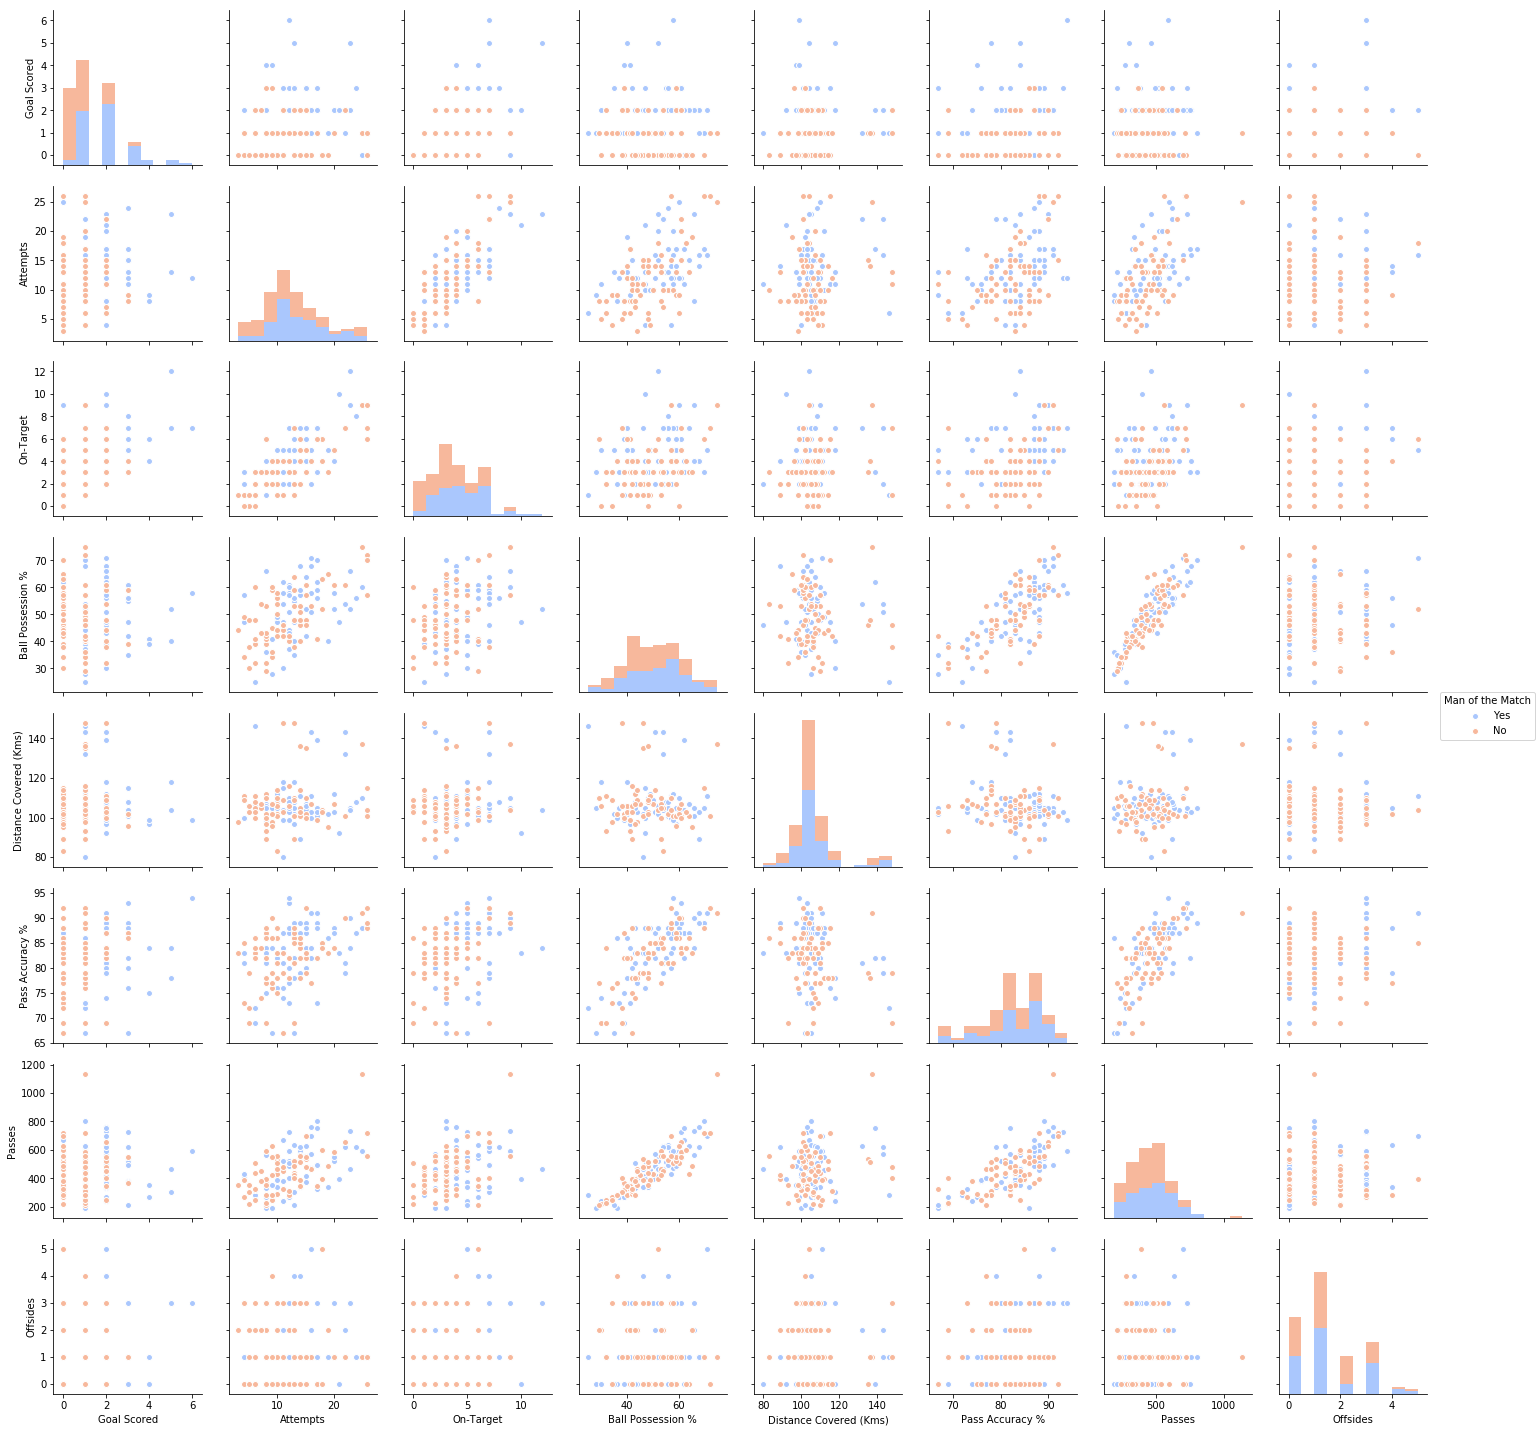

In [15]:
# pairplot of selected features and see if there is patterns we can discover
cols_to_pairplot = ['Goal Scored',
                   'Attempts',
                   'On-Target',
                   'Ball Possession %',
                   'Distance Covered (Kms)',
                   'Pass Accuracy %',
                   'Passes',
                   'Offsides',
                   'Man of the Match']
fifa_pair = fifa_18[cols_to_pairplot]
sns.pairplot(fifa_pair,hue='Man of the Match',palette='coolwarm')

The pairplot shows that most of the data has overlap, which means it cannot be distinguished directly from one single figure. The target must be related to several features. However, for Goal Scored feature, it can be observed that there are separate groups. It indicates that Goal Scored might have a large effect on the target prediction

### Model train and prediction
Use random forest to fit the model, the aim of the project is to examine the SHAP value related plots so the focus is not entirely on the method we use to train the model.

In [16]:
y = (fifa_18['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in fifa_18.columns if fifa_18[i].dtype in [np.int64, np.int64]]
X = fifa_18[feature_names]

In [17]:
# Split the train and test data and train with random forest algorithm
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.25, random_state=1)
my_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

### SHAP
SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value.

In [18]:
import shap  # package used to calculate Shap values

row_to_show = 5
data_for_prediction = val_X.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

# Create object that can calculate shap values
# use Tree SHAP to explain test set predictions
explainer = shap.TreeExplainer(my_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

The shap_values object above is a list with two arrays. The first array in the list is the SHAP values for a negative outcome (don't win the award.). The second array is the list of SHAP values for the positive outcome, which is how we 
usually think about predictions. It's cumbersome to review a raw array, but the shap package has a nice way to 
visualize the results. Before doing that, here are the predicted probabilities of each outcome

In [19]:
my_model.predict_proba(data_for_prediction_array)

array([[0.5, 0.5]])

if array is ([0.2 0.8]), The team is 80% likely to have a player win the award.

In [21]:
# Now we visualize the SHAP values
#shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

We predicted 0.8, whereas the base_value is 0.4979. Feature values causing increased predictions are in pink, and their visual size shows the magnitude of the feature's effect. Feature values decreasing the prediction are in blue. The biggest impact comes from Goal Scored being 2. Though the distance covered value has a meaningful effect decreasing the prediction.



In [22]:
# use Kernel SHAP to explain test set predictions
k_explainer = shap.KernelExplainer(my_model.predict_proba, train_X)
k_shap_values = k_explainer.shap_values(data_for_prediction)
shap.force_plot(k_explainer.expected_value[1], k_shap_values[1], data_for_prediction)

This time, we use Kernal Explainer (instead of Tree Explainer) to re-plot the SHAP values. Generally speaking, the result is similar to the one obtained by the Tree Explainer. The biggest impact is still from Goal Scored = 2, which is followed by Attempts = 13. Satisfying both will likely increase your chance of getting the award.

### SHAP Summary plots
We can also see the feature impact of all the variables on the output by using SHAP summary plot

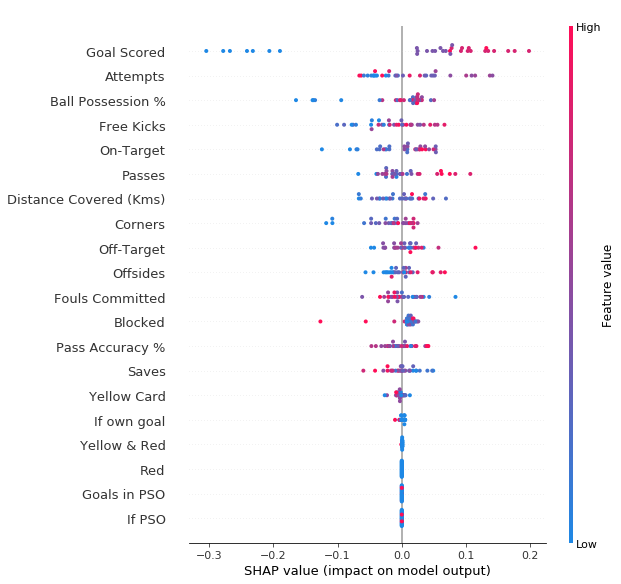

In [23]:
# calculate shap values. This is what we will plot.
explainer = shap.TreeExplainer(my_model)
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(val_X)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], val_X)

This SHAP summary plots show the impact of each feature on the prediction. As we expected, Goal Scored and Attempts are the biggest players in this prediction. Also, getting yellow or red literally has no effect on the result. With SHAP summary plot, it is more intuitive to tell the impact of each feature.

### SHAP Dependence Contribution Plots
Check the SHAP value for one feature with the interaction of another feature

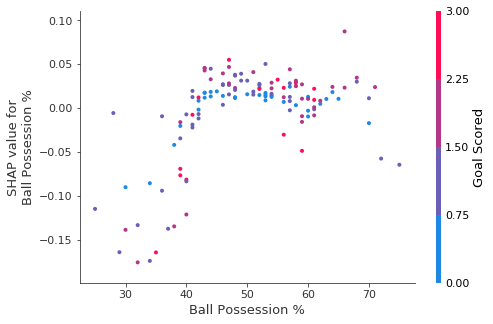

In [24]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)
# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X)

# If you don't supply an argument for interaction_index, Shapley uses some logic to pick one that may be interesting.
shap.dependence_plot('Ball Possession %', shap_values[1], X, interaction_index="Goal Scored")

Also, we just show that it is also capable of demonstrating the interaction of two features using SHAP values. Goal scored would have a positive influence on the SHAP values. Ball possession, however, is not quite important in this case.